# EDA for Earthquake project

With this notebook, let's have a look to the data from :
https://www.kaggle.com/c/LANL-Earthquake-Prediction

The 'acoustic_data' input signal is used to predict the time remaining before the next laboratory earthquake ('time_to_failure').

In order to make this kind of prediction, we are going to run a machine learning model over statistical features extracted from the dataset.
But this way, we need to select only interesting feature to save computationnal ressources.
My aim here is to extract pertinent features from the dataset. For that, i have to apply a statistical analysis to the dataset. Or at least to a part of the dataset.

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# Import data and visualize dataset
Note that the dataset file is 9.3Gb heavy

In [3]:
%%time
train = pd.read_csv(r'C:\Users\alexi\Documents\LANL-Earthquake-Prediction\train.csv', 
                    dtype={'acoustic_data': np.int16, 
                           'time_to_failure': np.float32})

FileNotFoundError: [Errno 2] File C:\Users\alexi\Documents\LANL-Earthquake-Prediction\train.csv does not exist: 'C:\\Users\\alexi\\Documents\\LANL-Earthquake-Prediction\\train.csv'

In [3]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


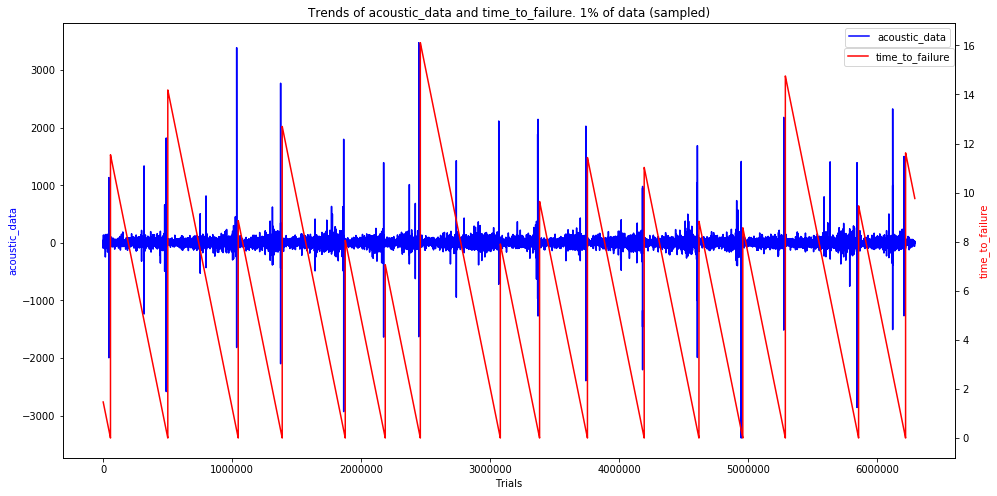

In [7]:
train_acoustic_data_small = train['acoustic_data'].values[::100]
train_time_to_failure_small = train['time_to_failure'].values[::100]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 1% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
ax1.set_xlabel('Trials')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

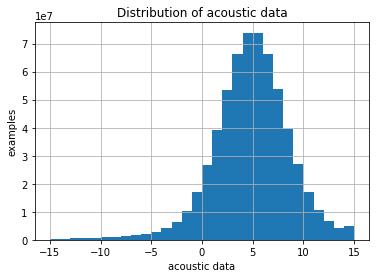

In [18]:
train['acoustic_data'].hist(bins=30, range = [-15,15], align='mid')
plt.title("Distribution of acoustic data")
plt.xlabel('acoustic data')
plt.ylabel('examples')
plt.show()

In [3]:
print("Mean value = ", train['acoustic_data'].mean())

Mean value =  4.513817517860374


In [7]:
print("Standard deviation = ", train['acoustic_data'][0:629145474].std())

Standard deviation =  10.735707296341316


# Feature extraction

To make it easier to see, I choose to select a segment [0:50085877] between the start and the first earthquake of the dataset.

Let's have a look at different features (mean, max, min, var, std) for different rolling windows (10, 100, 1000).

Then, we will try to see how these features are correlated in order to remove the less interesting ones


In [3]:
train_short = train.loc[0:50085877].copy()

In [4]:
train_short.loc[:,'mean_10']= train_short.acoustic_data.rolling(10).mean()
train_short.loc[:,'mean_100']= train_short.acoustic_data.rolling(100).mean()
train_short.loc[:,'mean_1000']= train_short.acoustic_data.rolling(1000).mean()
train_short.loc[:,'max_100']= train_short.acoustic_data.rolling(100).max()
train_short.loc[:,'min_100']= train_short.acoustic_data.rolling(100).min()
train_short.loc[:,'var_100']= train_short.acoustic_data.rolling(100).var()
train_short.loc[:,'std_100']= train_short.acoustic_data.rolling(100).std()
train_short.loc[:,'quantile_01_100']= train_short.acoustic_data.rolling(100).quantile(0.01)
train_short.loc[:,'quantile_05_100']= train_short.acoustic_data.rolling(100).quantile(0.05)
train_short.loc[:,'quantile_95_100']= train_short.acoustic_data.rolling(100).quantile(0.95)
train_short.loc[:,'quantile_99_100']= train_short.acoustic_data.rolling(100).quantile(0.99)

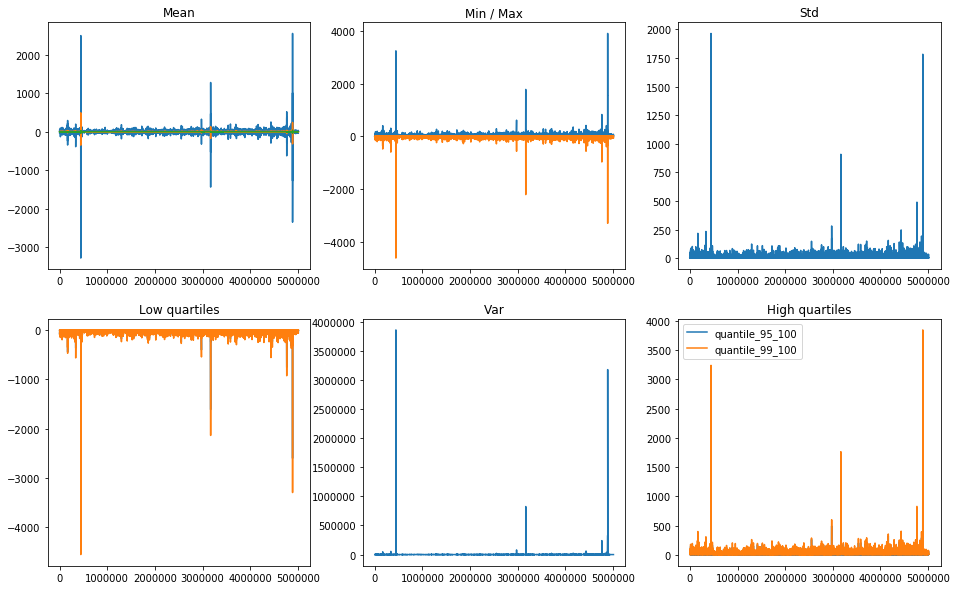

In [6]:
f, axarr = plt.subplots(2, 3,figsize=(16,10))

axarr[0, 0].plot(train_short.mean_10.values[::10], label = 'mean_10')
axarr[0, 0].plot(train_short.mean_100.values[::10], label = 'mean_100')
axarr[0, 0].plot(train_short.mean_1000.values[::10], label = 'mean_1000')
axarr[0, 0].set_title('Mean')

axarr[0, 1].plot(train_short.max_100.values[::10], label = 'max_100')
axarr[0, 1].plot(train_short.min_100.values[::10], label = 'min_100')
axarr[0, 1].set_title('Min / Max')

axarr[1, 0].plot(train_short.quantile_05_100.values[::10], label = 'quantile_05_100')
axarr[1, 0].plot(train_short.quantile_01_100.values[::10], label = 'quantile_01_100')
axarr[1, 0].set_title('Low quartiles')

axarr[1, 1].plot(train_short.var_100.values[::10], label = 'var_100')
axarr[1, 1].set_title('Var')

axarr[0, 2].plot(train_short.std_100.values[::10], label = 'std_100')
axarr[0, 2].set_title('Std')

axarr[1, 2].plot(train_short.quantile_95_100.values[::10], label = 'quantile_95_100')
axarr[1, 2].plot(train_short.quantile_99_100.values[::10], label = 'quantile_99_100')
axarr[1, 2].set_title('High quartiles')

plt.legend()
plt.show()

In [5]:
train_short.drop(columns=['mean_10', 'mean_1000']).dropna();

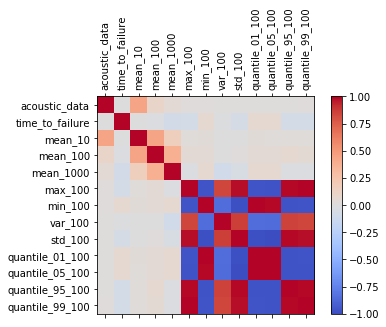

In [6]:
corr = train_short.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(train_short.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_short.columns)
ax.set_yticklabels(train_short.columns)
plt.show()

# EDA Conclusion 


First, we can see from the acoustic_data analysis that we have a mean value about 4.5195 and a standard deviation about 10.7357 . This will be usefull to scale data intervalls to run the model.

Secondly, we can see that rolling stats over 10 examples leads to lots of noise. on the other hand, over 1000 examples we are loosing too much information, sometimes even with 100 examples. Then rolling over 50 examples seems to be a good compromise.

Then, according to the correlation analysis, we can easily remove min_100 and select only one of the two low quantiles and one of the two high ones.